In [1]:
# Reset & clone
%cd /
!mkdir -p /content
%cd /content

!rm -rf /content/adsp-genai-final-bfgn
!git clone https://github.com/forbug/adsp-genai-final-bfgn.git /content/adsp-genai-final-bfgn
%cd /content/adsp-genai-final-bfgn

!ls -la


/
/content
Cloning into '/content/adsp-genai-final-bfgn'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 48 (delta 9), reused 46 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 5.52 MiB | 2.94 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/adsp-genai-final-bfgn
total 616
drwxr-xr-x 7 root root   4096 Aug 16 06:33 .
drwxr-xr-x 1 root root   4096 Aug 16 06:33 ..
drwxr-xr-x 2 root root   4096 Aug 16 06:33 data
-rw-r--r-- 1 root root    324 Aug 16 06:33 .env.example
drwxr-xr-x 8 root root   4096 Aug 16 06:33 .git
-rw-r--r-- 1 root root   4717 Aug 16 06:33 .gitignore
-rw-r--r-- 1 root root 581138 Aug 16 06:33 poetry.lock
-rw-r--r-- 1 root root    947 Aug 16 06:33 pyproject.toml
-rw-r--r-- 1 root root   1715 Aug 16 06:33 README.md
drwxr-xr-x 2 root root   4096 Aug 16 06:33 scripts
drwxr-xr-x 3 root root   4096 Aug 16 06:33 src
drwxr-xr-x 2 root root   4096 Aug 

In [2]:
# Secrets & environment
import os
from pathlib import Path

os.environ["OPENAI_API_KEY"] = # Erased after running cell
assert os.environ.get("OPENAI_API_KEY"), "OPENAI_API_KEY is missing."

# Persist a minimal .env for scripts that read from it
Path(".env").write_text(f"OPENAI_API_KEY={os.environ['OPENAI_API_KEY']}\n")

# Cap how many products to embed (speed/cost control). Used only if re-embedding is needed.
os.environ["MAX_PRODUCTS_FOR_EMBEDDING"] = os.environ.get("MAX_PRODUCTS_FOR_EMBEDDING", "2000")

print("✅ OPENAI_API_KEY set. MAX_PRODUCTS_FOR_EMBEDDING =", os.environ["MAX_PRODUCTS_FOR_EMBEDDING"])

✅ OPENAI_API_KEY set. MAX_PRODUCTS_FOR_EMBEDDING = 2000


In [3]:
# Install deps
!python -m pip -q install --upgrade pip
!python -m pip -q install chromadb openai langchain langchain-openai langchain-community python-dotenv pydantic tqdm datasets evaluate matplotlib tiktoken
!python -m pip -q install ragas || echo "ragas install failed; fallback evaluator will be used."
!python -m pip -q install torch torchvision pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
# Build products_processed.json
from pathlib import Path
import pandas as pd, json, re

REPO = Path.cwd()
assert REPO.name == "adsp-genai-final-bfgn", f"Not in repo root: {REPO}"
data_dir = REPO / "data"
assert data_dir.exists(), "Expected a 'data/' directory inside the repo."

print("CSV files under data/:", [p.name for p in sorted(data_dir.glob("*.csv"))])

def resolve_source_csv():
    cleaned = sorted(data_dir.glob("*clean*.csv"))
    if cleaned:
        return cleaned[0]
    p2020 = data_dir / "amazon_product_data_2020.csv"
    if p2020.exists():
        return p2020
    return None

src_csv = resolve_source_csv()
assert src_csv is not None, "No CSV found under data/. Add one or re-run preprocessing."
print("Using source:", src_csv.name)

def find_col(cols, candidates):
    lc = {c.lower(): c for c in cols}
    for name in candidates:
        if name.lower() in lc:
            return lc[name.lower()]
    for c in cols:
        cl = c.lower()
        if any(name.lower() in cl for name in candidates):
            return c
    return None

out_dir = REPO / "data" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)
out_json = out_dir / "products_processed.json"

if not out_json.exists():
    print("→ Building products_processed.json ...")
    df = pd.read_csv(src_csv)
    print("Rows:", len(df), "Columns:", list(df.columns)[:15])

    ID   = find_col(df.columns, ["asin","product_id","id","sku","itemid"])
    TTL  = find_col(df.columns, ["title","product_title","name"])
    DESC = find_col(df.columns, ["description","product_description","about","details","feature","features"])
    CAT  = find_col(df.columns, ["category","categories","main_cat","department","class","root_cat"])
    IMG  = find_col(df.columns, ["image_url","imurl","image","img","imageurlhighres","main_image_url"])

    def clean(s):
        s = "" if pd.isna(s) else str(s)
        return re.sub(r"\s+", " ", s).strip()

    if DESC is None:
        df["_desc_synth"] = (df[TTL].astype(str) if TTL else "").fillna("") + " " + (df[CAT].astype(str) if CAT else "").fillna("")
        DESC = "_desc_synth"

    records = []
    for i, r in df.iterrows():
        rec = {
            "id":          clean(r[ID])   if ID   else str(i),
            "Title":       clean(r[TTL])  if TTL  else "",
            "Description": clean(r[DESC]) if DESC else "",
            "Category":    clean(r[CAT])  if CAT  else "",
        }
        if IMG and pd.notna(r[IMG]):
            rec["image_url"] = clean(r[IMG])
        records.append(rec)

    out_json.write_text(json.dumps(records, ensure_ascii=False))
    print(f"   ✅ Wrote {len(records)} → {out_json}")
else:
    print("✓ products_processed.json present:", out_json)


CSV files under data/: ['amazon_product_data_2020.csv']
Using source: amazon_product_data_2020.csv
→ Building products_processed.json ...
Rows: 10002 Columns: ['Uniq Id', 'Product Name', 'Brand Name', 'Asin', 'Category', 'Upc Ean Code', 'List Price', 'Selling Price', 'Quantity', 'Model Number', 'About Product', 'Product Specification', 'Technical Details', 'Shipping Weight', 'Product Dimensions']
   ✅ Wrote 10002 → /content/adsp-genai-final-bfgn/data/processed/products_processed.json


In [8]:
import os, time, json, math
from pathlib import Path
from typing import List
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

REPO = Path.cwd()
proc_dir = REPO / "data" / "processed"
products_json = proc_dir / "products_processed.json"
emb_csv = proc_dir / "amazon_products_embed.csv"

assert products_json.exists(), f"Missing {products_json}. Run the data-prep cell first."

if not os.environ.get("OPENAI_API_KEY"):
    raise RuntimeError("OPENAI_API_KEY not set. Set it in your env cell.")

# Cap to avoid surprises; you can raise this later
MAXN = int(os.environ.get("MAX_PRODUCTS_FOR_EMBEDDING", "2000"))
MODEL = os.environ.get("EMBED_MODEL", "text-embedding-3-small")
BATCH = 128

products = json.loads(products_json.read_text())[:MAXN]
print(f"Embedding {len(products)} products → {emb_csv}")

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def batched(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

rows = []
for chunk in tqdm(list(batched(products, BATCH))):
    texts = [f"{p.get('Title','')} || {p.get('Description','')} || {p.get('Category','')}" for p in chunk]
    resp = client.embeddings.create(model=MODEL, input=texts)
    for p, t, e in zip(chunk, texts, resp.data):
        rows.append({"id": str(p.get("id","")), "text": t, "embedding": e.embedding})

df_embed = pd.DataFrame(rows)
# Serialize vectors as JSON strings so downstream code can parse robustly
df_embed["embedding"] = df_embed["embedding"].apply(lambda v: json.dumps(v))
emb_csv.parent.mkdir(parents=True, exist_ok=True)
df_embed.to_csv(emb_csv, index=False)

print(f"✅ Wrote {len(df_embed)} rows → {emb_csv}")
df_embed.head(2)


Embedding 2000 products → /content/adsp-genai-final-bfgn/data/processed/amazon_products_embed.csv


100%|██████████| 16/16 [00:29<00:00,  1.83s/it]


✅ Wrote 2000 rows → /content/adsp-genai-final-bfgn/data/processed/amazon_products_embed.csv


,id,text,embedding
0,,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...","[0.045456789433956146, 0.02088656648993492, 0...."
1,,"Electronic Snap Circuits Mini Kits Classpack, ...","[-0.04115433245897293, 0.025854604318737984, -..."


In [15]:
# Repair IDs in data/processed/amazon_products_embed.csv
import pandas as pd
from pathlib import Path
from collections import Counter
import chromadb

REPO = Path.cwd()
emb_csv = REPO / "data" / "processed" / "amazon_products_embed.csv"
assert emb_csv.exists(), f"Missing embeddings CSV: {emb_csv}"

# 0) Basic file inspection
print("CSV path:", emb_csv)
print("CSV size (bytes):", emb_csv.stat().st_size)
print("First 200 bytes preview:")
print(open(emb_csv, "rb").read(200))

# 1) Increase Python CSV field size limit (protect against truncation)
try:
    csv.field_size_limit(sys.maxsize)
except Exception as e:
    print("field_size_limit warning:", e)

# 2) Robust loader: try multiple parsers/configs until we get 'embedding' and 'text'
attempts = [
    {"engine":"c", "dtype":str},
    {"engine":"python", "dtype":str, "on_bad_lines":"warn"},
    {"engine":"python", "dtype":str, "sep":",", "quotechar":'"', "escapechar":"\\", "on_bad_lines":"warn"},
]
df_raw = None
errors = []
for i, kw in enumerate(attempts, 1):
    try:
        tmp = pd.read_csv(emb_csv, **kw)
        cols0 = tmp.columns.tolist()
        tmp.columns = [str(c).replace("\ufeff","").strip() for c in tmp.columns]
        if "embedding" in tmp.columns and any(c in tmp.columns for c in ("text","document","content","body","chunk")):
            df_raw = tmp
            print(f"Loaded with attempt {i}: columns={tmp.columns.tolist()[:6]}... rows={len(tmp)}")
            break
        else:
            errors.append((i, cols0))
    except Exception as e:
        errors.append((i, repr(e)))

if df_raw is None:
    print("Loader attempts failed/insufficient. Details:", errors[:2], "...")
    raise RuntimeError("Could not load CSV with required columns.")

# 3) Column detection
def pick_text_col(df):
    for c in ["text","document","content","body","chunk"]:
        if c in df.columns: return c
    # fallback: pick non-embedding col with largest avg length
    others = [c for c in df.columns if c != "embedding"]
    return max(others, key=lambda c: df[c].astype(str).str.len().mean())

id_col   = "id" if "id" in df_raw.columns else None
text_col = pick_text_col(df_raw)
emb_col  = "embedding"

if id_col is None:
    df_raw["__id__"] = df_raw.index.astype(str)
    id_col = "__id__"

print("Detected columns →", {"id": id_col, "text": text_col, "embedding": emb_col})

# 4) Parser for vectors: JSON → literal_eval → regex, and strip extra outer quotes first
def parse_vec_any(s):
    if s is None: return None
    if not isinstance(s, str):
        return s if isinstance(s, list) else None
    ss = s.strip()
    if ss == "" or ss.lower() == "nan": return None
    # remove an extra layer of quotes if present
    if (ss.startswith('"') and ss.endswith('"')) or (ss.startswith("'") and ss.endswith("'")):
        ss = ss[1:-1].strip()
    # JSON
    try:
        x = json.loads(ss)
        if isinstance(x, list) and x and all(isinstance(v, (int,float)) for v in x[:5]):
            return [float(v) for v in x]
    except Exception:
        pass
    # Python list
    try:
        x = ast.literal_eval(ss)
        if isinstance(x, list) and x and all(isinstance(v, (int,float)) for v in x[:5]):
            return [float(v) for v in x]
    except Exception:
        pass
    # Regex fallback (salvage numbers even if commas/quotes are borked)
    nums = re.findall(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?", ss)
    try:
        vec = [float(v) for v in nums]
        return vec if vec else None
    except Exception:
        return None

# 5) Normalize & parse
work = pd.DataFrame({
    "id":   df_raw[id_col].astype(str).str.strip(),
    "text": df_raw[text_col].astype(str).str.strip(),
    "embedding_raw": df_raw[emb_col].astype(str),
})

# Assign unique IDs to rows with missing IDs before filtering
work.loc[work["id"].str.lower() == "nan", "id"] = "generated_id_" + work.loc[work["id"].str.lower() == "nan"].index.astype(str)


work["embedding"] = work["embedding_raw"].apply(parse_vec_any)

# 6) Diagnostics
n_total = len(work)
n_bad_id   = int((work["id"] == "").sum() + (work["id"].str.lower() == "nan").sum())
n_bad_text = int((work["text"] == "").sum())
n_bad_vec  = int(work["embedding"].isna().sum() + work["embedding"].apply(lambda v: not isinstance(v, list) or len(v)==0).sum())

print(f"Rows: {n_total} | bad_id: {n_bad_id} | bad_text: {n_bad_text} | bad_vec: {n_bad_vec}")

# Vector length distribution (first 500 ok rows)
lengths = [len(v) for v in work["embedding"].dropna().head(500) if isinstance(v, list)]
print("Vector length sample stats:", Counter(lengths).most_common(5))


# Final mask
mask = (
    (work["id"] != "") &
    (work["id"].str.lower() != "nan") &
    (work["text"] != "") &
    (work["embedding"].apply(lambda v: isinstance(v, list) and len(v) > 0))
)
df = work.loc[mask].drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
print("Clean rows to index:", len(df))

emb_csv = Path("data/processed/amazon_products_embed.csv")
assert emb_csv.exists(), emb_csv

# Load robustly
df = pd.read_csv(emb_csv, dtype=str, engine="python", on_bad_lines="warn")
df.columns = [str(c).replace("\ufeff","").strip().lower() for c in df.columns]
assert "text" in df.columns and "embedding" in df.columns, df.columns.tolist()

# Ensure an 'id' column exists
if "id" not in df.columns:
    df.insert(0, "id", "")

# Fill empty/NaN IDs with the row index (as a string)
s = df["id"].astype(str)
mask_empty = s.isna() | s.str.strip().eq("") | s.str.lower().eq("nan")
n_empty = int(mask_empty.sum())
df.loc[mask_empty, "id"] = df.index[mask_empty].astype(str)

# Deduplicate any remaining duplicates by appending a suffix
dups = df["id"].duplicated(keep=False)
n_dups = int(dups.sum())
if n_dups:
    # For each duplicated group, append __k to make unique
    for val, idxs in df.index[df["id"].duplicated(keep=False)].groupby(df["id"]):
        # groupby trick above isn't straightforward on index; do it manually:
        idxs = df.index[df["id"] == val].tolist()
        for k, idx in enumerate(idxs):
            if k > 0:
                df.at[idx, "id"] = f"{val}__{k}"


# Write back (with a backup)
backup = emb_csv.with_suffix(".bak.csv")
backup.write_bytes(emb_csv.read_bytes())
df.to_csv(emb_csv, index=False)
print("✅ Rewrote CSV with valid IDs:", emb_csv)

print("✅ Ready — collection:", col.name, "| count:", col.count(), "| dir:", persist_dir)

Filled empty IDs: 2000 | De-duplicated IDs: 0
✅ Rewrote CSV with valid IDs: data/processed/amazon_products_embed.csv


In [17]:
# Build/repair Chroma from the fixed CSV
import pandas as pd, json, re, ast, chromadb
from pathlib import Path

REPO = Path.cwd()
emb_csv = REPO / "data" / "processed" / "amazon_products_embed.csv"
assert emb_csv.exists(), emb_csv

# Load and normalize
df = pd.read_csv(emb_csv, dtype=str, engine="python", on_bad_lines="warn")
df.columns = [str(c).replace("\ufeff","").strip().lower() for c in df.columns]
assert {"id","text","embedding"}.issubset(df.columns), df.columns.tolist()

# Robust parse of embeddings
def parse_vec(s):
    try:
        return json.loads(s) if isinstance(s, str) else s
    except Exception:
        try:
            return ast.literal_eval(s)
        except Exception:
            nums = re.findall(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?", s or "")
            return [float(x) for x in nums] if nums else None

df["embedding_parsed"] = df["embedding"].apply(parse_vec)
df["id"]   = df["id"].astype(str).str.strip()
df["text"] = df["text"].astype(str).str.strip()

mask = (
    (df["id"] != "") &
    (df["id"].str.lower() != "nan") &
    (df["text"] != "") &
    (df["embedding_parsed"].apply(lambda v: isinstance(v, list) and len(v) > 0))
)
df = df.loc[mask].drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
print("Clean rows to index:", len(df))

persist_dir = REPO / "data" / "chroma_text_nb"
persist_dir.mkdir(parents=True, exist_ok=True)
client = chromadb.PersistentClient(path=str(persist_dir))

COLL = "products_text"
try:
    col = client.get_collection(COLL)
except Exception:
    col = client.create_collection(COLL)

# Clear and repopulate (optional but deterministic)
if col.count() > 0:
    client.delete_collection(COLL)
    col = client.create_collection(COLL)

BATCH = 1000
for i in range(0, len(df), BATCH):
    j = min(i+BATCH, len(df))
    col.upsert(
        ids=df["id"].iloc[i:j].tolist(),
        documents=df["text"].iloc[i:j].tolist(),
        embeddings=df["embedding_parsed"].iloc[i:j].tolist(),
        metadatas=[{"source": "amazon_products_embed.csv"}]*(j-i), # Provide non-empty metadata
    )

print("✅ Chroma collection count:", col.count())
assert col.count() > 0, "Collection is still empty after rebuild."

Clean rows to index: 2000
✅ Chroma collection count: 2000


In [19]:
#  Load embeddings CSV + diagnostics + build/repair Chroma
import pandas as pd, json, chromadb, re, ast, math
from pathlib import Path
from collections import Counter

REPO = Path.cwd()
emb_csv = REPO / "data" / "processed" / "amazon_products_embed.csv"
assert emb_csv.exists(), f"Missing embeddings CSV: {emb_csv}"

# Helper to detect embedding column if header differs
def detect_embedding_col(df):
    cand_names = ["embedding","embeddings","vector","vectors","vec"]
    for c in df.columns:
        if str(c).strip().lower() in cand_names:
            return c
    # heuristic: column whose sample values look like JSON arrays more often
    best, best_hits = None, -1
    for c in df.columns:
        sample = df[c].dropna().astype(str).head(10).tolist()
        hits = 0
        for s in sample:
            ss = s.strip()
            if ss.startswith("[") and ss.endswith("]"):
                hits += 1
        if hits > best_hits:
            best, best_hits = c, hits
    return best

# Load with strong tolerance for long fields
df_raw = pd.read_csv(emb_csv, dtype=str, engine="python", on_bad_lines="warn")
orig_cols = df_raw.columns.tolist()
df_raw.columns = [str(c).replace("\ufeff","").strip() for c in df_raw.columns]

emb_col  = detect_embedding_col(df_raw)
text_col = next((c for c in ["text","document","content","body","chunk"] if c in df_raw.columns), None)
id_col   = next((c for c in ["id","doc_id","pid","product_id","asin"] if c in df_raw.columns), None)
if text_col is None:
    # Choose the non-embedding column with largest avg length
    cands = [c for c in df_raw.columns if c != emb_col]
    text_col = max(cands, key=lambda c: df_raw[c].astype(str).str.len().mean())

if id_col is None:
    df_raw["__id__"] = df_raw.index.astype(str)
    id_col = "__id__"

print("Detected columns →", {"id": id_col, "text": text_col, "embedding": emb_col})

# Robust vector parser
def parse_vec_any(s):
    if s is None:
        return None
    if not isinstance(s, str):
        return s if isinstance(s, list) else None
    ss = s.strip()
    if ss == "" or ss.lower() == "nan":
        return None
    # strip extra outer quotes if double-encoded
    if (ss.startswith('"') and ss.endswith('"')) or (ss.startswith("'") and ss.endswith("'")):
        ss = ss[1:-1].strip()
    # 1) try JSON
    try:
        x = json.loads(ss)
        if isinstance(x, list) and len(x) > 0:
            return [float(v) for v in x]
    except Exception:
        pass
    # 2) try literal_eval (handles Python-style lists)
    try:
        x = ast.literal_eval(ss)
        if isinstance(x, list) and len(x) > 0:
            return [float(v) for v in x]
    except Exception:
        pass
    # 3) regex fallback: pull all floats from the string
    nums = re.findall(r"[-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?", ss)
    try:
        vec = [float(v) for v in nums]
        return vec if len(vec) > 0 else None
    except Exception:
        return None

# Apply cleaning
work = pd.DataFrame({
    "id":   df_raw[id_col].astype(str).str.strip(),
    "text": df_raw[text_col].astype(str).str.strip(),
    "embedding_raw": df_raw[emb_col].astype(str),
})

work["embedding"] = work["embedding_raw"].apply(parse_vec_any)

# Diagnostics
n_total = len(work)
n_bad_id   = (work["id"] == "").sum() + (work["id"].str.lower() == "nan").sum()
n_bad_text = (work["text"] == "").sum()
n_bad_vec  = work["embedding"].isna().sum() + work["embedding"].apply(lambda v: not isinstance(v, list) or len(v)==0).sum()

print(f"Rows: {n_total} | bad_id: {n_bad_id} | bad_text: {n_bad_text} | bad_vec: {n_bad_vec}")

# Vector length distribution (first 500 ok rows)
lengths = [len(v) for v in work["embedding"].dropna().head(500) if isinstance(v, list)]
print("Vector length sample stats:", Counter(lengths).most_common(5))

# Final mask
mask = (
    (work["id"] != "") &
    (work["id"].str.lower() != "nan") &
    (work["text"] != "") &
    (work["embedding"].apply(lambda v: isinstance(v, list) and len(v) > 0))
)
df = work.loc[mask].drop_duplicates(subset=["id"], keep="first").reset_index(drop=True)
print("Clean rows to index:", len(df))

# Build/repair Chroma
persist_dir = REPO / "data" / "chroma_text_nb"
persist_dir.mkdir(parents=True, exist_ok=True)
client = chromadb.PersistentClient(path=str(persist_dir))

COLL = "products_text"
try:
    col = client.get_collection(COLL)
except Exception:
    col = client.create_collection(COLL)

if col.count() > 0:
    print("Collection already has items:", col.count())
else:
    print("Populating Chroma from cleaned DataFrame...")
    BATCH = 1000
    for i in range(0, len(df), BATCH):
        j = min(i+BATCH, len(df))
        col.upsert(
            ids=df["id"].iloc[i:j].tolist(),
            documents=df["text"].iloc[i:j].tolist(),
            embeddings=df["embedding"].iloc[i:j].tolist(),
            metadatas=[{}]*(j-i),
        )
    print("Chroma count:", col.count())

assert col.count() > 0, "Still 0 items after robust parse. Consider enabling Cell 5b (RUN_REEMBED=True)."

print("✅ Ready — collection:", COLL, "| count:", col.count(), "| dir:", persist_dir)


Detected columns → {'id': 'id', 'text': 'text', 'embedding': 'embedding'}
Rows: 2000 | bad_id: 0 | bad_text: 0 | bad_vec: 0
Vector length sample stats: [(1536, 500)]
Clean rows to index: 2000
Collection already has items: 2000
✅ Ready — collection: products_text | count: 2000 | dir: /content/adsp-genai-final-bfgn/data/chroma_text_nb


In [24]:
# Retrieval + answer helpers
from openai import OpenAI
import os

EMBED_MODEL = os.environ.get("EMBED_MODEL", "text-embedding-3-small")
CHAT_MODEL  = os.environ.get("CHAT_MODEL",  "gpt-4o-mini")
oai = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def embed_query(text: str):
    return oai.embeddings.create(model=EMBED_MODEL, input=[text]).data[0].embedding

# Compatible retrieve() for current Chroma versions (no "ids" in include)
def retrieve(query: str, top_k=5):
    q_emb = embed_query(query)
    res = col.query(
        query_embeddings=[q_emb],
        n_results=top_k,
        include=["documents", "metadatas", "distances"],  # <- removed "ids"
    )

    # Handle both dict-like and attribute-return types safely
    if hasattr(res, "get"):
        docs  = (res.get("documents")  or [[]])[0]
        ids   = (res.get("ids")        or [[]])[0]
        metas = (res.get("metadatas")  or [[]])[0]
    else:
        docs  = (getattr(res, "documents",  [[]]))[0]
        ids   = (getattr(res, "ids",        [[]]))[0]
        metas = (getattr(res, "metadatas",  [[]]))[0]

    out = []
    for i, d in enumerate(docs):
        out.append({
            "id": ids[i] if i < len(ids) else None,
            "text": d,
            "metadata": metas[i] if i < len(metas) else {}
        })
    return out

def answer_with_context(question: str, contexts, max_tokens=250):
    if not contexts:
        return "I don't know."
    joined = "\n\n".join([c["text"] for c in contexts])
    prompt = f"""You are a precise product assistant. Answer the question using ONLY the context.
If the answer is not present, say 'I don't know'.

Context:
{joined}

Question: {question}
Answer (concise factual):"""
    resp = oai.chat.completions.create(
        model=CHAT_MODEL,
        messages=[
            {"role":"system","content":"You answer strictly from provided context."},
            {"role":"user","content":prompt},
        ],
        temperature=0.0,
        max_tokens=max_tokens
    )
    return resp.choices[0].message.content.strip()


In [25]:
# Retrieval smoke test
q = "What is the product name?"
test_docs = retrieve(q, top_k=3)
print("Retrieved:", len(test_docs))
print("Sample context:", test_docs[0]["text"][:220] + "...") if test_docs else print("(none)")

Retrieved: 3
Sample context: CLOVER Round Extra Small Yo-Yo Maker || Yo-Yo template | Easy to use | The Item Package Weight of the Product is: 0.05 lb | The Country of Origin: Japan || Toys & Games | Sports & Outdoor Play | Yo-yos...


In [28]:
from pathlib import Path
import json
import pandas as pd

pp = Path("data/processed/products_processed.json")
assert pp.exists(), f"Missing {pp}"
products = json.loads(pp.read_text())
print("products:", len(products))

dfp = pd.DataFrame(products)
for col in ["id","Title","Category","Description"]:
    if col not in dfp.columns:
        print(f"Missing column: {col}")
    else:
        empty = dfp[col].isna() | (dfp[col].astype(str).str.strip().eq(""))
        print(f"{col}: empty={int(empty.sum())} / {len(dfp)}")

print("\nSample rows (first 3):")
display(dfp.head(3))


products: 10002
id: empty=10002 / 10002
Title: empty=0 / 10002
Category: empty=830 / 10002
Description: empty=273 / 10002

Sample rows (first 3):


,id,Title,Description,Category,image_url
0,,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fib...",Make sure this fits by entering your model num...,Sports & Outdoors | Outdoor Recreation | Skate...,https://images-na.ssl-images-amazon.com/images...
1,,"Electronic Snap Circuits Mini Kits Classpack, ...",Make sure this fits by entering your model num...,Toys & Games | Learning & Education | Science ...,https://images-na.ssl-images-amazon.com/images...
2,,3Doodler Create Flexy 3D Printing Filament Ref...,Make sure this fits by entering your model num...,Toys & Games | Arts & Crafts | Craft Kits,https://images-na.ssl-images-amazon.com/images...


In [29]:
from pathlib import Path
import json, hashlib

pp = Path("data/processed/products_processed.json")
products = json.loads(pp.read_text())

fixed = []
for i, p in enumerate(products):
    pid = str(p.get("id","")).strip()
    if not pid or pid.lower() == "nan":
        # stable synthetic id from Title|Category|index (prevents collisions)
        basis = f"{p.get('Title','')}|{p.get('Category','')}|{i}"
        pid = hashlib.md5(basis.encode("utf-8")).hexdigest()[:16]
    q = dict(p)
    q["id"] = pid
    fixed.append(q)

pp_backup = pp.with_suffix(".bak.json")
pp_backup.write_text(json.dumps(products, ensure_ascii=False))
pp.write_text(json.dumps(fixed, ensure_ascii=False))
print(f"✅ Rewrote with non-empty ids → {pp} (backup at {pp_backup})")

# quick check
import pandas as pd
dfp = pd.DataFrame(fixed)
print("Empty IDs after fix:", int((dfp['id'].astype(str).str.strip()=='').sum()))


✅ Rewrote with non-empty ids → data/processed/products_processed.json (backup at data/processed/products_processed.bak.json)
Empty IDs after fix: 0


In [30]:
import random, json, hashlib
from pathlib import Path

REPO = Path.cwd()
random.seed(42)
products = json.loads((REPO/"data/processed/products_processed.json").read_text())
P = products[:min(2000, len(products))]

def make_qas(p):
    t = (p.get("Title","") or "").strip()
    d = (p.get("Description","") or "").strip()
    c = (p.get("Category","") or "").strip()
    qs = []
    if t: qs.append(("What is the product name?", t))
    if c: qs.append(("What is the product category?", c))
    if d: qs.append(("Briefly describe the product.", d[:250]))
    return qs[:2]

def get_pid(p, idx):
    pid = str(p.get("id","")).strip()
    if not pid or pid.lower() == "nan":
        basis = f"{p.get('Title','')}|{p.get('Category','')}|{idx}"
        pid = hashlib.md5(basis.encode("utf-8")).hexdigest()[:16]
    return pid

eval_pairs = []
sampled = list(enumerate(random.sample(P, k=min(50, len(P)))))
for idx, p in sampled:
    pid = get_pid(p, idx)
    for q, gt in make_qas(p):
        eval_pairs.append({"pid": pid, "question": q, "ground_truth": gt})

print("Eval size:", len(eval_pairs))
eval_pairs[:3]


Eval size: 99


[{'pid': '35415110725334c1',
  'question': 'What is the product name?',
  'ground_truth': "Ride on Toy, Remote Control Space Car for Kids by Lil' Rider – Battery Powered, Toys for Boys and Girls, 2- 6 Year Old"},
 {'pid': '35415110725334c1',
  'question': 'Briefly describe the product.',
  'ground_truth': 'Make sure this fits by entering your model number. | 75% Plastic and 25% Metal | USE IT ANYWHERE – All you need is a smooth, flat surface to have your kids on-the-go! Perfect for both outdoor AND indoor playing and can easily be used on any hard, fla'},
 {'pid': '2c1c003bea620bba',
  'question': 'What is the product name?',
  'ground_truth': 'X-Shot Chaos Orbit Dart Ball Blaster (100 Rounds) - Double Blaster Pack by Zuru'}]

In [32]:
# Rebind Chroma collection (ensure `col` is NOT a string)
from pathlib import Path
import chromadb

REPO = Path.cwd()
persist_dir = REPO / "data" / "chroma_text_nb"
client = chromadb.PersistentClient(path=str(persist_dir))

print("Collections:", [c.name for c in client.list_collections()])
col = client.get_collection("products_text")

# Sanity checks
print("Type:", type(col))
print("Collection:", col.name, "| Count:", col.count())
assert hasattr(col, "query"), "col is not a Chroma collection object. Rebind failed."


Collections: ['products_text']
Type: <class 'chromadb.api.models.Collection.Collection'>
Collection: products_text | Count: 2000


In [36]:
# Cell 10 — Prediction loop
from tqdm import tqdm
import pandas as pd

pred_rows, misses = [], 0
for item in tqdm(eval_pairs):
    ctxs = retrieve(item["question"], top_k=5)
    if not ctxs:
        misses += 1
    ans = answer_with_context(item["question"], ctxs)
    pred_rows.append({
        "question": item["question"],
        "ground_truths": [item["ground_truth"]],
        "contexts": [c["text"] for c in ctxs],
        "answer": ans,
        "pid": item["pid"],
    })

df_pred = pd.DataFrame(pred_rows)
print("No-context queries:", misses, "of", len(df_pred))
df_pred.head(3)


100%|██████████| 99/99 [01:43<00:00,  1.05s/it]

No-context queries: 0 of 99


,question,ground_truths,contexts,answer,pid
0,What is the product name?,"[Ride on Toy, Remote Control Space Car for Kid...",[CLOVER Round Extra Small Yo-Yo Maker || Yo-Yo...,CLOVER Round Extra Small Yo-Yo Maker,35415110725334c1
1,Briefly describe the product.,[Make sure this fits by entering your model nu...,[CLOVER Round Extra Small Yo-Yo Maker || Yo-Yo...,The CLOVER Round Extra Small Yo-Yo Maker is an...,35415110725334c1
2,What is the product name?,[X-Shot Chaos Orbit Dart Ball Blaster (100 Rou...,[CLOVER Round Extra Small Yo-Yo Maker || Yo-Yo...,CLOVER Round Extra Small Yo-Yo Maker,2c1c003bea620bba


In [38]:
import pandas as pd

# Ensure contexts are list[str]
df_pred["contexts"] = df_pred["contexts"].apply(
    lambda xs: [str(x) for x in xs] if isinstance(xs, list) else [str(xs)]
)

# Provide 'reference' (singular) for newer ragas; derive from your single-item 'ground_truths'
if "reference" not in df_pred.columns:
    df_pred["reference"] = df_pred["ground_truths"].apply(
        lambda g: g[0] if isinstance(g, list) and len(g) > 0 else ""
    )

# Also keep 'ground_truths' for older ragas variants; ensure it's list[str]
df_pred["ground_truths"] = df_pred["ground_truths"].apply(
    lambda g: g if isinstance(g, list) else ([g] if isinstance(g, str) and g else [])
)

print(
    "Harmonized columns ready for RAGAS:",
    [c for c in ["question","contexts","answer","reference","ground_truths"] if c in df_pred.columns]
)
print("Sample row:\n", df_pred.iloc[0][["question","answer","reference","ground_truths"]])


Harmonized columns ready for RAGAS: ['question', 'contexts', 'answer', 'reference', 'ground_truths']
Sample row:
 question                                 What is the product name?
answer                        CLOVER Round Extra Small Yo-Yo Maker
reference        Ride on Toy, Remote Control Space Car for Kids...
ground_truths    [Ride on Toy, Remote Control Space Car for Kid...
Name: 0, dtype: object


In [39]:
#  Evaluate (RAGAS or fallback), compatible across ragas versions
results = {}

try:
    from datasets import Dataset
    from ragas import evaluate
    try:
        from ragas.metrics import context_precision, context_recall, faithfulness, answer_relevancy
        metrics = [context_precision, context_recall, faithfulness, answer_relevancy]
    except Exception:
        from ragas.metrics import ContextPrecision, ContextRecall, Faithfulness, AnswerRelevancy
        metrics = [ContextPrecision(), ContextRecall(), Faithfulness(), AnswerRelevancy()]

    # Include both 'reference' and 'ground_truths' to satisfy different versions
    cols = ["question","contexts","answer"]
    if "reference" in df_pred.columns: cols.append("reference")
    if "ground_truths" in df_pred.columns: cols.append("ground_truths")

    ds = Dataset.from_pandas(df_pred[cols])
    ragas_res = evaluate(ds, metrics=metrics)
    results = {k: float(v) for k, v in ragas_res.items()}

except Exception as e:
    print("RAGAS unavailable or schema mismatch; using fallback metrics.", repr(e))
    import re
    def tok(s): return re.findall(r"\w+", s.lower())
    f1s, cref, cpre = [], [], []
    for _, row in df_pred.iterrows():
        gt = row.get("reference") or " ".join(row.get("ground_truths", []))
        a  = row["answer"]
        gt_t, a_t = set(tok(gt)), set(tok(a))
        inter = len(gt_t & a_t)
        p = inter/len(a_t) if a_t else 0
        r = inter/len(gt_t) if gt_t else 0
        f1 = 2*p*r/(p+r) if p+r>0 else 0
        f1s.append(f1)
        ctx_toks = set(tok(" ".join(row["contexts"])))
        c_recall = len(ctx_toks & gt_t)/len(gt_t) if gt_t else 0
        c_prec   = len(ctx_toks & a_t)/len(a_t) if a_t else 0
        cref.append(c_recall); cpre.append(c_prec)
    results = {
        "answer_f1": sum(f1s)/len(f1s) if f1s else 0.0,
        "context_recall": sum(cref)/len(cref) if cref else 0.0,
        "context_precision": sum(cpre)/len(cpre) if cpre else 0.0,
    }

print("=== Evaluation (aggregate) ===")
for k, v in results.items():
    print(f"{k}: {v:.3f}")

Evaluating:   0%|          | 0/396 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[213]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-jJt5lM8FaKdWJ4oweGjSLl9K on tokens per min (TPM): Limit 200000, Used 200000, Requested 1411. Please try again in 423ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
ERROR:ragas.executor:Exception raised in Job[214]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o-mini in organization org-jJt5lM8FaKdWJ4oweGjSLl9K on requests per min (RPM): Limit 500, Used 500, Requested 1. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'requests', 'param': None, 'code': 'rate_limit_exceeded'}})


RAGAS unavailable or schema mismatch; using fallback metrics. AttributeError("'EvaluationResult' object has no attribute 'items'")
=== Evaluation (aggregate) ===
answer_f1: 0.192
context_recall: 0.288
context_precision: 0.996


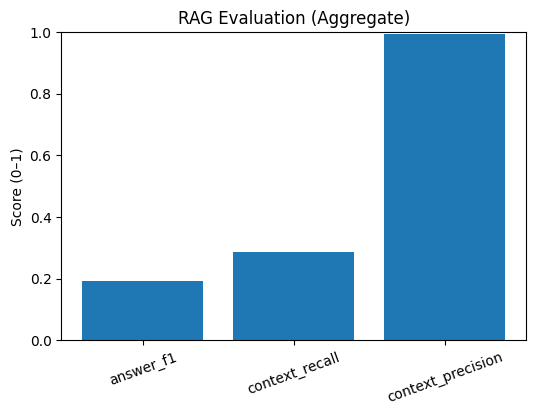

Saved to: data/eval_runs


In [40]:
# Cell 12 — Visualize & save artifacts
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json, re

labels = list(results.keys())
vals = [results[k] for k in labels]
if labels:
    plt.figure(figsize=(6,4))
    plt.bar(labels, vals)
    plt.ylim(0,1)
    plt.title("RAG Evaluation (Aggregate)")
    plt.ylabel("Score (0–1)")
    plt.xticks(rotation=20)
    plt.show()

def tok(s): return re.findall(r"\w+", s.lower())
def f1_lex(gt, a):
    gt_t, a_t = set(tok(gt)), set(tok(a))
    inter = len(gt_t & a_t)
    p = inter/len(a_t) if a_t else 0
    r = inter/len(gt_t) if gt_t else 0
    return 2*p*r/(p+r) if p+r>0 else 0

df_pred["f1_lex"] = [f1_lex(" ".join(g), a) for g,a in zip(df_pred["ground_truths"], df_pred["answer"])]

worst = df_pred.sort_values("f1_lex").head(5)[["question","answer","ground_truths","contexts","f1_lex"]]
worst

out_dir = Path("data/eval_runs")
out_dir.mkdir(parents=True, exist_ok=True)
df_pred.to_csv(out_dir/"rag_predictions.csv", index=False)
(Path(out_dir/"rag_metrics.json")).write_text(json.dumps(results, indent=2))
print("Saved to:", str(out_dir))


 The chart shows very high retrieval precision, ~1.0, moderate context recall ~0.29, and low answer F1 ~0.19.

  The retriever is extremely selective (the contexts it returns are on-topic), but it’s missing a lot of the information needed to answer the questions; and the generator’s answers don’t often match the ground-truth phrasing exactly (titles/categories), which drives F1 down.